## Weekly exercise, week 41

Unfortunately, we did not have time to implement all of this week's tasks, as we chose to spend a while setting up generalizable code infrastructure that can be used as is in our final project. We hope you are okay with this prioritization, and have made a plan to finish this  over the weekend. Please let us know if we should submit the full code for correction at a later time.

We have done the three first tasks. Our plan for implementing learning rate methods is to include the cost function (with regularization if specified) in the base class, and then have a method of if-tests that handles eta if learning rate tuning is specified. We plan on calling this method from the `perform` method. 

We also struggle with the regularization term, so that we can perform the same analysis for Ridge. We think it's a quick fix, but have not prioritized it.

In [ ]:
from abc import ABC, abstractmethod

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
class GD(ABC):
    def __init__(
            self,
            eta: float,
            delta_momentum: float | None,
            max_iter: int, 
            tol: float, 
            rng: np.random.Generator | None,
        ) -> None:
        """
        Initialize base class for gradient descent methods.

        Args:
            max_iter (int): maximum number of iterations before termination.
            tol (int): terminate when cost is below `tol`.
            rng (np.random.Generator or None): random generator. If None, rng.random.default_rng(None) is used.

        Returns:
            None
        """
        self.eta = eta
        # self.eta_tuner = eta_tuner        # TODO: implement learning rate tuners
        self.delta_momentum = delta_momentum
        self.max_iter = max_iter
        self.tol = tol
        if rng is None:
            rng = np.random.default_rng(None)
        self.rng = rng

        # if eta_tuner is None:
        #     self.tune = False
        # else:
        #     if not (eta_tuner in ["adagrad, rmsprop, adam"]):
        #         raise ValueError
        #     self.tune = True

        if delta_momentum is None:
            self.momentum = False
        else:
            self.momentum = True

        self.gradient = None
        self.cost = None
        self.X = None
        self.y = None
        self.lmbda = 0
        self.X_num_rows = None
        self.X_num_cols = None
    
    def set_cost(self):
        """
        Not yet implemented correctly. Will be used when learning rate tuning is implemented.
        """
        self.cost = lambda X, y, beta: (1/self.X_num_rows) * np.sum((y - (X @ beta))**2)
        # TODO: Fix this
        # if self.lmbda:
        #     self.cost = lambda X, y, beta: self.cost(X, y, beta) + self.lmbda * np.sum(beta**2)

    @abstractmethod
    def set_gradient(self, X: np.ndarray, y: np.ndarray, lmbda: float | int = 0) -> None:
        """
        Setter method??
        """
        self.X = X
        self.y = y
        self.lmbda = lmbda
        self.X_num_rows, self.X_num_cols = X.shape
        self.set_cost()
        # raise NotImplementedError

    @abstractmethod
    def perform(self):
        raise NotImplementedError
    
    def add_momentum(self, delta, delta_0):
        delta += self.delta_momentum * delta_0
        delta_0 = delta
        return delta, delta_0

In [3]:
class PlainGD(GD):
    def __init__(
            self, 
            eta: float = 0.01,
            eta_tuner: str | None = None,
            delta_momentum: float | None = None,
            max_iter: int = 50, 
            tol: float = 1e-8, 
            rng: np.random.Generator | None = None,
        ) -> None:
        super().__init__(eta, delta_momentum, max_iter, tol, rng)

    def set_gradient(self, X: np.ndarray, y: np.ndarray, lmbda: float | int = 0) -> None:
        super().set_gradient(X, y, lmbda)
        self.gradient = lambda beta: (2.0/self.X_num_rows) * X.T @ (X @ beta - y)
        # TODO: FIX THIS
        # if lmbda:
        #     gradient = lambda beta: self.gradient(beta) + 2*lmbda*beta
        #     self.gradient = gradient

    def perform(self) -> np.ndarray:
        """
        Performs the descent iteratively.

        Args:
            Tol (float): when to terminate.

        Returns:
            (np.ndarray): beta.
        """
        cost = 10 # TODO: change this to the actual cost
        beta = self.rng.random(self.X_num_cols)
        i = 0
        delta_0 = 0.0
        while (cost > self.tol) and (i < self.max_iter):
            delta = self.eta * self.gradient(beta)
            if self.momentum:
                delta, delta_0 = self.add_momentum(delta, delta_0)
            beta -= delta
            i += 1
        return beta

In [4]:
class StochasticGD(GD):
    def __init__(
            self, 
            eta: float = 0.01,
            delta_momentum: float | None = None,
            max_iter: int = 50,
            tol: float = 10e-8, 
            rng: np.random.Generator | None = None, 
            M: int = 5, 
            num_epochs: int = 50, 
            t0: int = 5, 
            t1: int = 50
        ) -> None:
        super().__init__(eta, delta_momentum, max_iter, tol, rng)

        self.M = M
        self.num_epochs = num_epochs
        self.t0 = t0
        self.t1 = t1

    def set_gradient(self, X: np.ndarray, y: np.ndarray,  lmbda: float | int = 0) -> None:
        super().set_gradient(X, y, lmbda)
        self.gradient = lambda beta, xi, yi: (2.0/self.X_num_rows) * xi.T @ (xi @ beta - yi)
        # TODO: FIX THIS
        # if lmbda:
        #     gradient = lambda beta, xi, yi: self.gradient(beta, xi, yi) + 2*lmbda*beta
        #     self.gradient = gradient

    def learning_schedule(self, t: int) -> float:
        return self.t0/(t+self.t1)
    
    def perform(self) -> np.ndarray:
        m = int(self.X_num_cols/self.M)
        beta = self.rng.random(self.X_num_cols)
        delta_0 = 0.0
        for epoch in range(self.num_epochs):
            m_range = np.arange(0, m - 1)
            self.rng.shuffle(m_range)
            for k in m_range:
                xk = self.X[k:k+self.M]
                yk = self.y[k:k+self.M]
                eta = self.learning_schedule(epoch*m + k)
                delta = eta*self.gradient(beta, xk, yk)
                if self.momentum:
                    delta, delta_0 = self.add_momentum(delta, delta_0)
                beta -= delta
        return beta

In [5]:
n = 20
rng = np.random.default_rng(10)
x = np.linspace(0, 1, n)
y = 2*x
X = np.c_[np.ones(n), x]


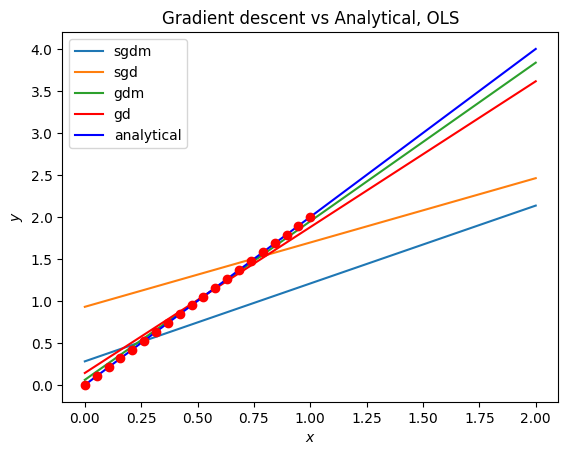

In [6]:
GD = PlainGD(eta=0.2)
GD.set_gradient(X, y)
beta = GD.perform()

GDM = PlainGD(eta=0.2, delta_momentum=0.3)
GDM.set_gradient(X, y)
betam = GDM.perform()

SGD = StochasticGD(eta=0.2, t0=1, t1=10)
SGD.set_gradient(X, y)
betasgd = SGD.perform()

SGDM = StochasticGD(eta=0.02, delta_momentum=0.3, t0=0.1, t1=1)
SGDM.set_gradient(X, y)
betasgdm = SGDM.perform()

beta_linreg = np.linalg.pinv(X.T @ X) @ X.T @ y

xnew = np.array([[0],[2]])
xbnew = np.c_[np.ones((2,1)), xnew]
ypredictsgd = xbnew.dot(betasgd)
ypredictm = xbnew.dot(betam)
ypredict = xbnew.dot(beta)
ypredictsgdm = xbnew.dot(betasgdm)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredictsgdm, label="sgdm")
plt.plot(xnew, ypredictsgd, label = "sgd")
plt.plot(xnew, ypredictm, label="gdm")
plt.plot(xnew, ypredict, "r-", label="gd")
plt.plot(xnew, ypredict2, "b-", label="analytical")
plt.plot(x, y ,'ro')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent vs Analytical, OLS')
plt.legend()
plt.show()

We see that the gradient descent methods does not perform as well as the analytical. This makes sence since the anaytical is exact, and gradient descent is a numerical approach. We think that if we had spent some more time on tuning the parameters, the results would be better.